In [12]:
%run setup.ipynb
%run ../gwss/setup.ipynb
%run peak-utils.ipynb 

In [48]:
@numba.njit(nogil=True)
def pair_diffs(x, y):
    n = x.shape[0]
    d = 0
    for i in range(n):
        d += (x[i] != y[i])
    return d
    

@numba.njit(nogil=True)
def pairwise_diffs_between(h1, h2):
    n1 = h1.shape[1]
    n2 = h2.shape[1]
    out = np.empty((n1, n2), dtype=np.int32)
    for i in range(n1):
        for j in range(n2):
            out[i, j] = pair_diffs(h1[:, i], h2[:, j])
    return out.flatten()


In [49]:
h1 = np.array([[0, 0, 1], [1, 0, 0]])
h2 = np.array([[0, 1, 1], [1, 1, 1]])
pairwise_diffs_between(h1, h2)

array([0, 1, 1, 1, 2, 2, 2, 1, 1], dtype=int32)

In [34]:
df_haps_a.head()

,label,ox_code,population,label_aug,country,region,sex,m_s
0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [35]:
df_haps_x.head()

,label,ox_code,population,label_aug,country,region,sex,m_s
0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [17]:
import dask

In [87]:
bphh_root = zarr.open(str(here() / 'data/gwss/bphh/bphh.zarr'))

In [104]:
def run_bphh(pop1, pop2, chromosome, window_size, n=50, seed=42, threshold=1):
    np.random.seed(seed)

    # avoid running the same scan twice
    pop1, pop2 = sorted([pop1, pop2])

    # setup zarr group to store data
    grp_path = f'/{pop1}_{pop2}_{chromosome}_{window_size}_{n}_{seed}_{threshold}'
    grp = bphh_root.require_group(grp_path)
    complete = grp.attrs.get('complete', False)

    if complete:
        # previously run, load from zarr
        windows = grp['windows'][:]
        gwindows = grp['gwindows'][:]
        bphh = grp['bphh'][:]

    else:
        
        print('loading haplotypes')
        if chromosome == 'X':
            pos = callset_haps[chromosome]['variants/POS'][:]
            ht = allel.GenotypeDaskArray(callset_haps[chromosome]['calldata/GT']).to_haplotypes().values

            # locate haplotypes for populations
            loc_pop1 = df_haps_x.query(pop_defs[pop1]['query']).index.values
            if len(loc_pop1) > n:
                loc_pop1 = sorted(np.random.choice(loc_pop1, size=n, replace=False))
            loc_pop2 = df_haps_x.query(pop_defs[pop2]['query']).index.values
            if len(loc_pop2) > n:
                loc_pop2 = sorted(np.random.choice(loc_pop2, size=n, replace=False))
            ht_pop1 = da.take(ht, loc_pop1, axis=1).compute()
            ht_pop2 = da.take(ht, loc_pop2, axis=1).compute()

        else:

            # concatenate data from both arms
            # remember, right arm goes on the left
            arm_r = f'{chromosome}R'
            arm_l = f'{chromosome}L'
            pos_r = callset_haps[arm_r]['variants/POS'][:]
            pos_l = callset_haps[arm_l]['variants/POS'][:]
            pos = np.concatenate([pos_r, pos_l + len(genome[arm_r])])
            ht_r = allel.GenotypeDaskArray(callset_haps[arm_r]['calldata/GT']).to_haplotypes().values
            ht_l = allel.GenotypeDaskArray(callset_haps[arm_l]['calldata/GT']).to_haplotypes().values
            ht = da.concatenate([ht_r, ht_l], axis=0)

            # locate haplotypes for populations
            loc_pop1 = df_haps_a.query(pop_defs[pop1]['query']).index.values
            if len(loc_pop1) > n:
                loc_pop1 = sorted(np.random.choice(loc_pop1, size=n, replace=False))
            loc_pop2 = df_haps_a.query(pop_defs[pop2]['query']).index.values
            if len(loc_pop2) > n:
                loc_pop2 = sorted(np.random.choice(loc_pop2, size=n, replace=False))
            ht_pop1 = da.take(ht, loc_pop1, axis=1).compute()
            ht_pop2 = da.take(ht, loc_pop2, axis=1).compute()

        # perform the scan
        print('running scan')
        gpos = np.take(gmap[chromosome], pos-1)
        windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_size)
        gwindows = allel.moving_statistic(gpos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_size)
        ix_windows = list(allel.stats.window.index_windows(ht, size=window_size, step=window_size, start=0, stop=None))
    #     result = np.array([
    #         pairwise_diffs_between(ht_pop1[i:j], ht_pop2[i:j])
    #         for i, j in ix_windows
    #     ], dtype=int)
        delayed_f = dask.delayed(pairwise_diffs_between)
        result, = dask.compute([
            delayed_f(ht_pop1[i:j], ht_pop2[i:j])
            for i, j in ix_windows
        ])
        result = np.array(result)
        bphh = (result <= threshold).sum(axis=1) / result.shape[1]

        # store results
        grp.create_dataset('windows', data=windows, overwrite=True)
        grp.create_dataset('gwindows', data=gwindows, overwrite=True)
        grp.create_dataset('bphh', data=bphh, overwrite=True)
        grp.attrs['complete'] = True

    return windows, gwindows, bphh
    

In [105]:
pops = sorted(pop_defs)
pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [107]:
for pop1, pop2 in itertools.combinations(pops, 2):
    for chromosome in '23X':
        for window_size in 1000, 2000:
            run_bphh(pop1, pop2, chromosome, window_size=window_size, n=50);

In [173]:
def plot_bphh(pop1, pop2, chromosome, window_size, n=50, ax=None, markersize=1):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 1), facecolor='w')
        sns.despine(ax=ax, offset=3)

    # load data
    windows, gwindows, bphh = run_bphh(pop1, pop2, chromosome, window_size=window_size, n=n)
    x = windows.mean(axis=1) / 1e6
    
    # plot data
    color = sns.color_palette()[0]
    color = 'k'
    ax.plot(x, bphh, linestyle=' ', marker='o', color=color, markersize=markersize)
    
    # tidy plot
    ax.set_xlim(0, chromosome_plen[chromosome] / 1e6)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim(0, 1)
    ax.set_yscale('symlog', linthresh=0.2)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))

In [174]:
sns.set_style('white')
sns.set_style('ticks')

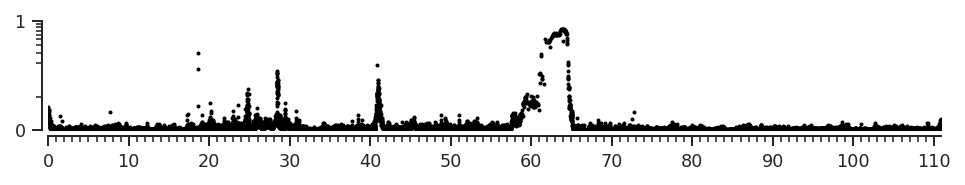

In [175]:
plot_bphh('ci_col', 'bf_col', '2', window_size=1000)

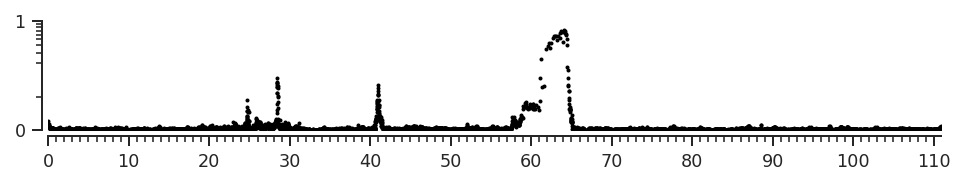

In [176]:
plot_bphh('ci_col', 'bf_col', '2', window_size=2000)

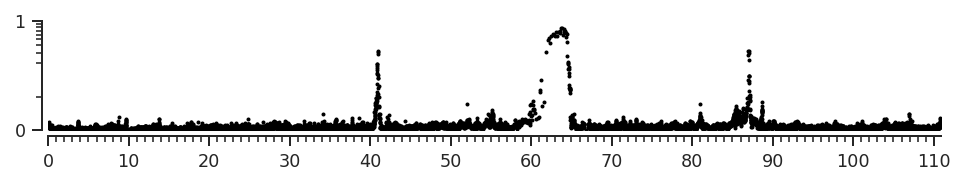

In [177]:
plot_bphh('ci_col', 'gh_col', '2', window_size=2000)

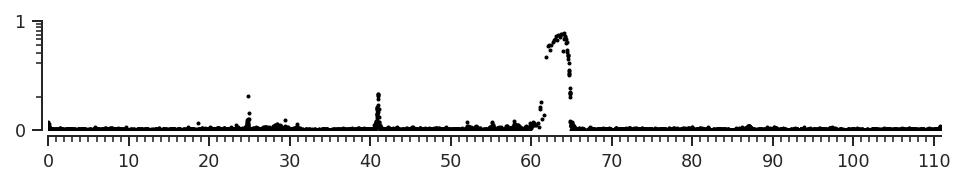

In [178]:
plot_bphh('bf_col', 'gh_col', '2', window_size=2000)

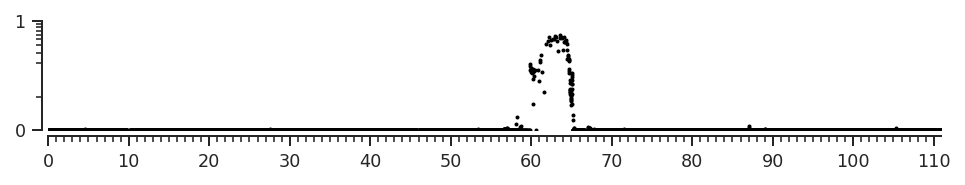

In [179]:
plot_bphh('bf_col', 'ao_col', '2', window_size=2000)

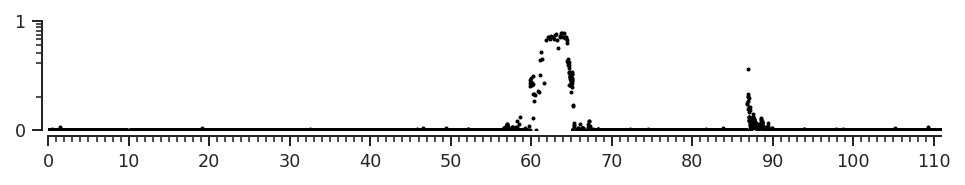

In [180]:
plot_bphh('ci_col', 'ao_col', '2', window_size=2000)

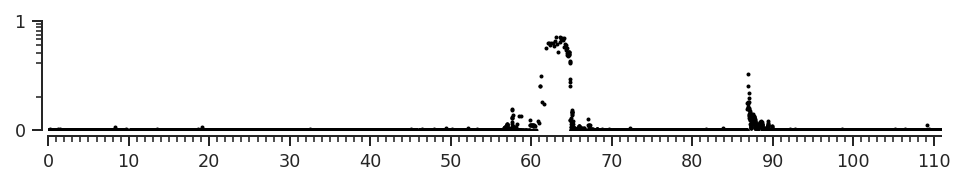

In [181]:
plot_bphh('gh_col', 'ao_col', '2', window_size=2000)

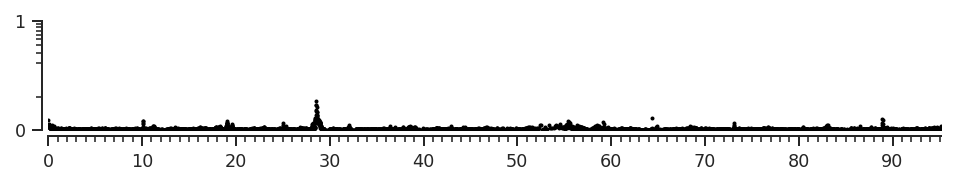

In [182]:
plot_bphh('ci_col', 'bf_col', '3', window_size=2000)

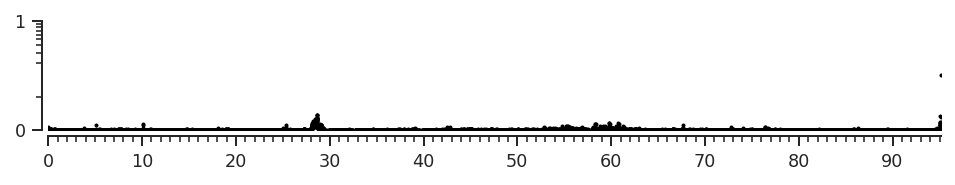

In [184]:
plot_bphh('bf_gam', 'bf_col', '3', window_size=1000)

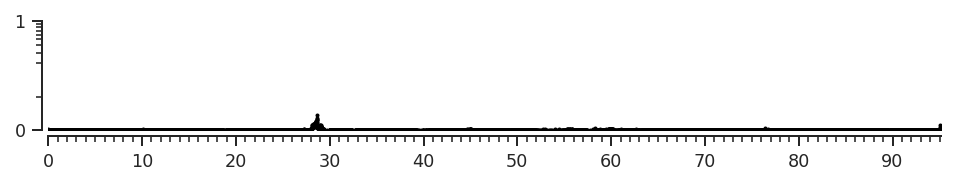

In [185]:
plot_bphh('bf_gam', 'bf_col', '3', window_size=2000)

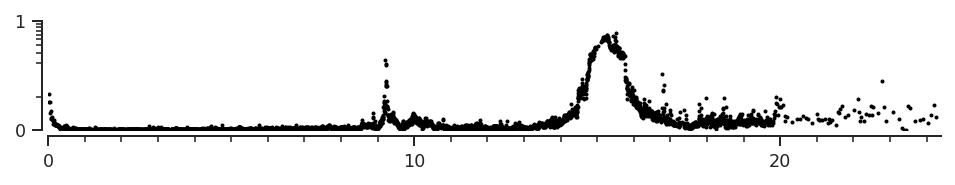

In [186]:
plot_bphh('ci_col', 'bf_col', 'X', window_size=1000)

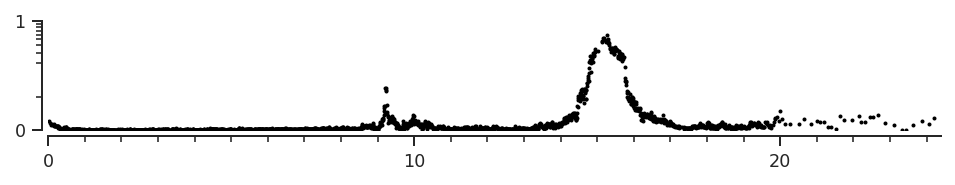

In [187]:
plot_bphh('ci_col', 'bf_col', 'X', window_size=2000)

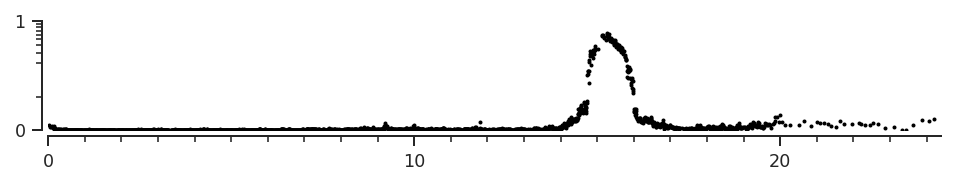

In [188]:
plot_bphh('gh_col', 'bf_col', 'X', window_size=2000)

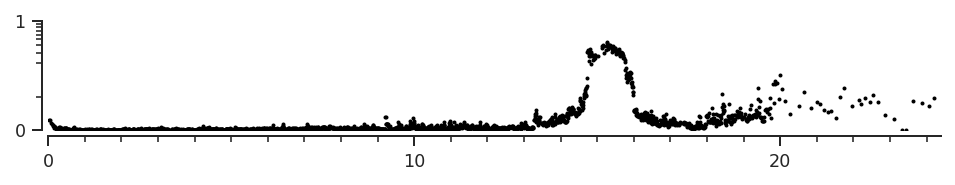

In [189]:
plot_bphh('gh_col', 'ci_col', 'X', window_size=2000)

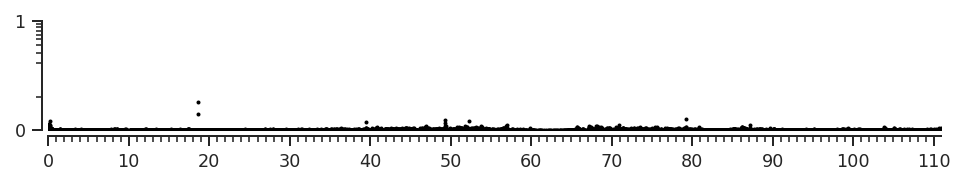

In [191]:
plot_bphh('bf_gam', 'ug_gam', '2', window_size=2000)

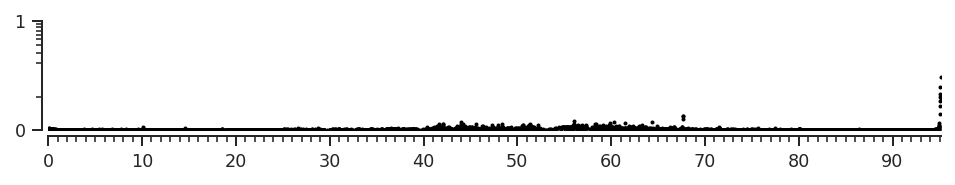

In [192]:
plot_bphh('bf_gam', 'ug_gam', '3', window_size=2000)

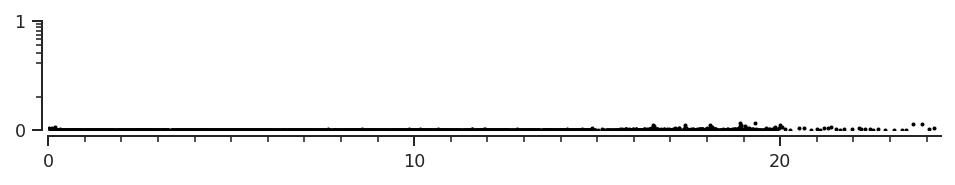

In [190]:
plot_bphh('bf_gam', 'ug_gam', 'X', window_size=2000)

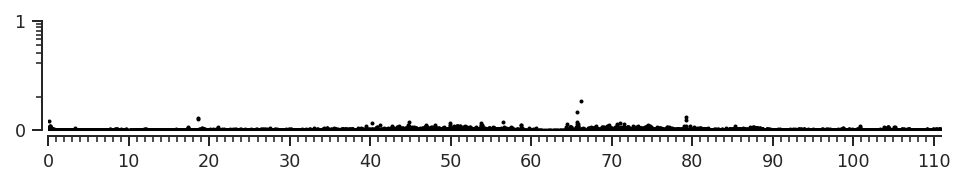

In [193]:
plot_bphh('cm_sav_gam', 'ug_gam', '2', window_size=2000)

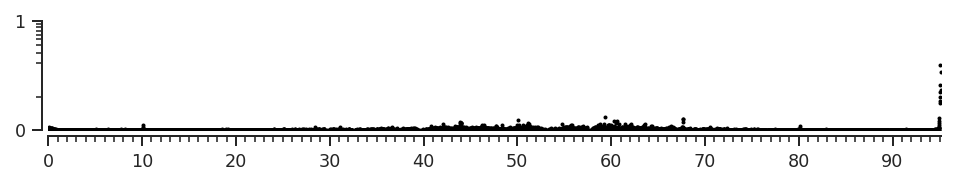

In [195]:
plot_bphh('cm_sav_gam', 'ug_gam', '3', window_size=2000)

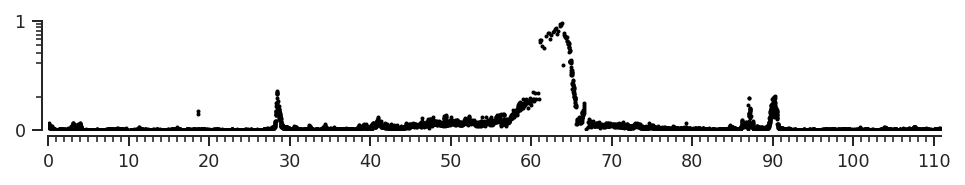

In [196]:
plot_bphh('bf_gam', 'gn_gam', '2', window_size=2000)

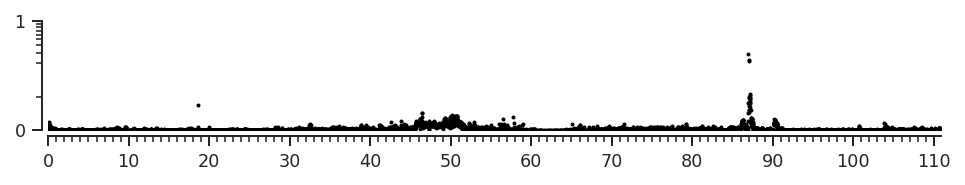

In [197]:
plot_bphh('bf_gam', 'ga_gam', '2', window_size=2000)

loading haplotypes
running scan


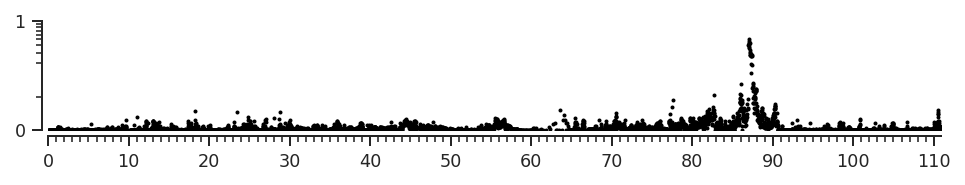

In [199]:
plot_bphh('gq_gam', 'ga_gam', '2', window_size=3000)

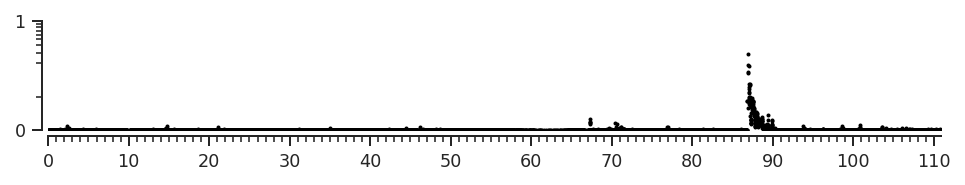

In [201]:
plot_bphh('ao_col', 'ga_gam', '2', window_size=2000)

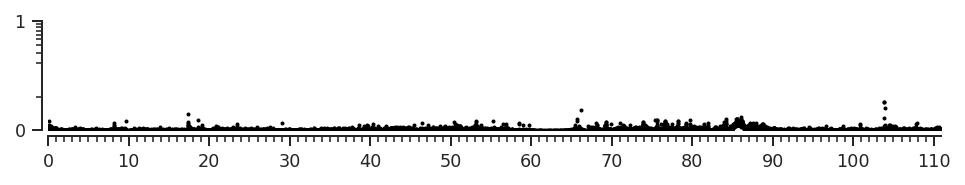

In [202]:
plot_bphh('ug_gam', 'ga_gam', '2', window_size=2000)

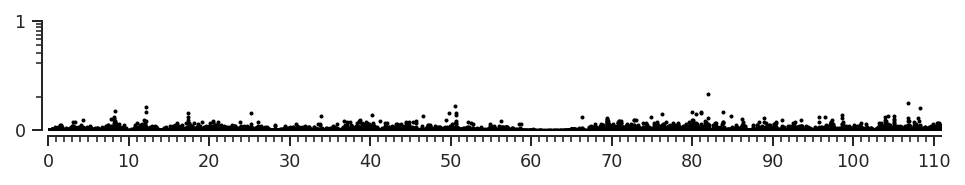

In [203]:
plot_bphh('ug_gam', 'fr_gam', '2', window_size=2000)

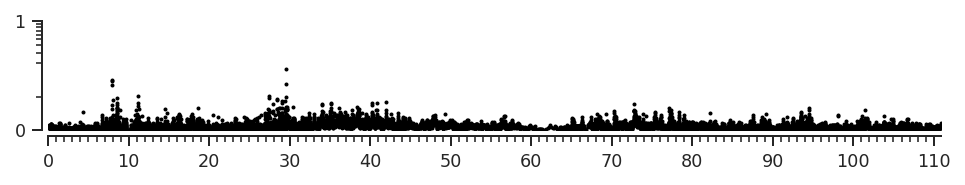

In [204]:
plot_bphh('gw', 'gm', '2', window_size=2000)

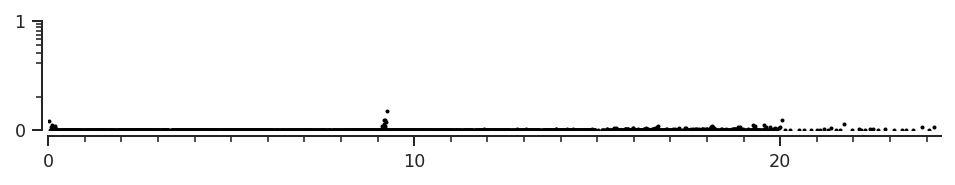

In [212]:
plot_bphh('gm', 'bf_gam', 'X', window_size=2000)

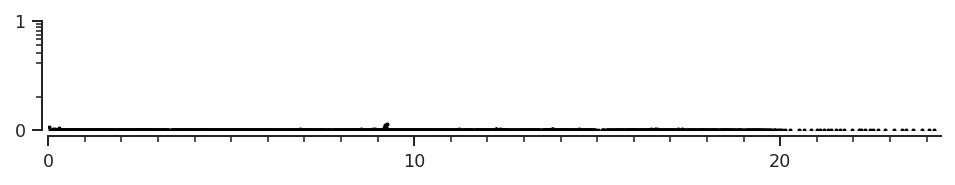

In [211]:
plot_bphh('gm', 'bf_col', 'X', window_size=2000)

Adaptation at locus @@ is being facilitated at least in part by gene flow between countries and species.

In [213]:
df_samples

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,AY0087-C,Tia_dPM_46,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,101458232,32.56,ERS311822,5.89839,-4.82293
1138,AY0088-C,Tia_dPM_52,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,95140584,30.75,ERS311830,5.89839,-4.82293
1139,AY0089-C,Tia_aPM_4,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,92383724,29.04,ERS311838,5.89839,-4.82293
1140,AY0090-C,Tia_aPM_13,CIcol,Cote d'Ivoire,Tiassale,Tiassale,David Weetman,David Weetman,2012,M,F,96210618,30.94,ERS311846,5.89839,-4.82293


In [214]:
df_samples.groupby('population').size()

population
AOcol     78
BFcol     75
BFgam     92
CIcol     71
CMgam    297
FRgam     24
GAgam     69
GHcol     55
GHgam     12
GM        65
GNcol      4
GNgam     40
GQgam      9
GW        91
KE        48
UGgam    112
dtype: int64